<a href="https://colab.research.google.com/github/ctruciosm/BasicStats/blob/main/MANOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MANOVA
By Carlos Trucíos

In [ ]:
install.packages("dplyr")
install.packages("mnt")
install.packages("car")
install.packages("biotools")

In [ ]:
library(dplyr)
library(mnt)
library(car)
library(biotools)

In [3]:
# Importar dados
pottery <- read.table("https://online.stat.psu.edu/onlinecourses/sites/stat505/files/data/pottery.txt")
glimpse(pottery)

Rows: 26
Columns: 6
$ V1 <chr> "L", "L", "L", "L", "L", "L", "L", "L", "L", "L", "L", "L", "L", "L…
$ V2 <dbl> 14.4, 13.8, 14.6, 11.5, 13.8, 10.9, 10.1, 11.6, 11.1, 13.4, 12.4, 1…
$ V3 <dbl> 7.00, 7.08, 7.09, 6.37, 7.06, 6.26, 4.26, 5.78, 5.49, 6.92, 6.13, 6…
$ V4 <dbl> 4.30, 3.43, 3.88, 5.64, 5.34, 3.47, 4.26, 5.91, 4.52, 7.23, 5.69, 5…
$ V5 <dbl> 0.15, 0.12, 0.13, 0.16, 0.20, 0.17, 0.20, 0.18, 0.29, 0.28, 0.22, 0…
$ V6 <dbl> 0.51, 0.17, 0.20, 0.14, 0.20, 0.22, 0.18, 0.16, 0.30, 0.20, 0.54, 0…


In [4]:
# OneWay MANOVA
manova_oneway <- manova(cbind(V2, V3, V4, V5, V6) ~ V1, data = pottery)
summary(manova_oneway)

          Df Pillai approx F num Df den Df    Pr(>F)    
V1         3 1.5539   4.2984     15     60 2.413e-05 ***
Residuals 22                                            
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [5]:
# Verificando as suposições
res <- residuals(manova_oneway)
#mardia(res)
mnt::test.BHEP(res, MC.rep = 1000)

  |======================================================================| 100%



------------------------------------------------------------------------- 

         Test for multivariate normality with the BHEP  teststatistic.

tuning parameter = 1  
BHEP  =  1.289364  
critical value =   0.8489413  (via monte carlo) 


------------------------------------------------------------------------- 

In [6]:
# Transformações
medidas <- pottery %>% dplyr::select(-V1)

lambda <- powerTransform(medidas)$lambda
pottery_transformed <- bcPower(medidas, lambda)
colnames(pottery_transformed) = colnames(medidas)

pottery_transformed <- pottery_transformed %>% mutate(V1 = pottery$V1)

In [7]:
# MANOVA dados transformados
manova_oneway <- manova(cbind(V2, V3, V4, V5, V6) ~ V1, data = pottery_transformed)
summary(manova_oneway)

          Df Pillai approx F num Df den Df    Pr(>F)    
V1         3 1.8458   6.3967     15     60 7.954e-08 ***
Residuals 22                                            
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [8]:
# Verificando as suposições
res <- residuals(manova_oneway)
mnt::test.BHEP(res, MC.rep = 1000)

  |======================================================================| 100%



------------------------------------------------------------------------- 

         Test for multivariate normality with the BHEP  teststatistic.

tuning parameter = 1  
BHEP  =  0.665699  
critical value =   0.8372657  (via monte carlo) 


------------------------------------------------------------------------- 

In [9]:
biotools::boxM(pottery_transformed[,c("V2", "V3", "V4", "V5")], pottery_transformed$V1)

Warning message in biotools::boxM(pottery_transformed[, c("V2", "V3", "V4", "V5")], :
“there are one or more levels with less observations than variables!”



	Box's M-test for Homogeneity of Covariance Matrices

data:  pottery_transformed[, c("V2", "V3", "V4", "V5")]
Chi-Sq (approx.) = 50.743, df = 30, p-value = 0.01037


# Gabarito: Estudo de Simulação
## (Questão 3 da Lista 2)



In [ ]:
# Instalamos pacotes
install.packages("DescTools")     # CramerVonMisesTest
install.packages("tseries")       # shapiro.test

In [ ]:
# Carregamos pacotes
library(DescTools)
library(tseries)
options(warn = -1)

In [12]:
# Definimos alguns parametros
replicacoes <- 5000
size_n <- c(10, 20, 50, 100, 500, 1000)

In [13]:
# Criamos Tabelas para salvar os resultados
p_valores <- matrix(NA, ncol = 4, nrow = replicacoes)
tabela <- matrix(NA, ncol = 4, nrow = length(size_n))
# Nomes às colunas e linhas para ajudar nas análises
colnames(tabela) <- c("KS", "Jarque-Bera", "Shapiro", "Cramer")
row.names(tabela) <- size_n

In [14]:
# Estudo de Simulação Quando H0 é verdadeiro
for (j in 1:length(size_n)) {
  for (i in 1:replicacoes) {
    ## Controlamos a semente
    set.seed(i)
    ## Simulamos dados
    x <- rnorm(size_n[j])
    ## Aplicamos os testes
    p_valores[i, ] <- c(ks.test(x, "pnorm")$p.value, 
                        jarque.bera.test(x)$p.value,
                        shapiro.test(x)$p.value,
                        CramerVonMisesTest(x)$p.value)
  }
  ## Calculamos a proporcao de vezes que rejeitamos H0
  tabela[j, ] <- apply(p_valores < 0.05, 2, mean)
}
tabela

,KS,Jarque-Bera,Shapiro,Cramer
10,0.0524,0.0110,0.0518,0.0516
20,0.0490,0.0204,0.0478,0.0492
50,0.0454,0.0326,0.0498,0.0500
100,0.0466,0.0412,0.0526,0.0520
500,0.0480,0.0422,0.0504,0.0472
1000,0.0512,0.0506,0.0536,0.0512


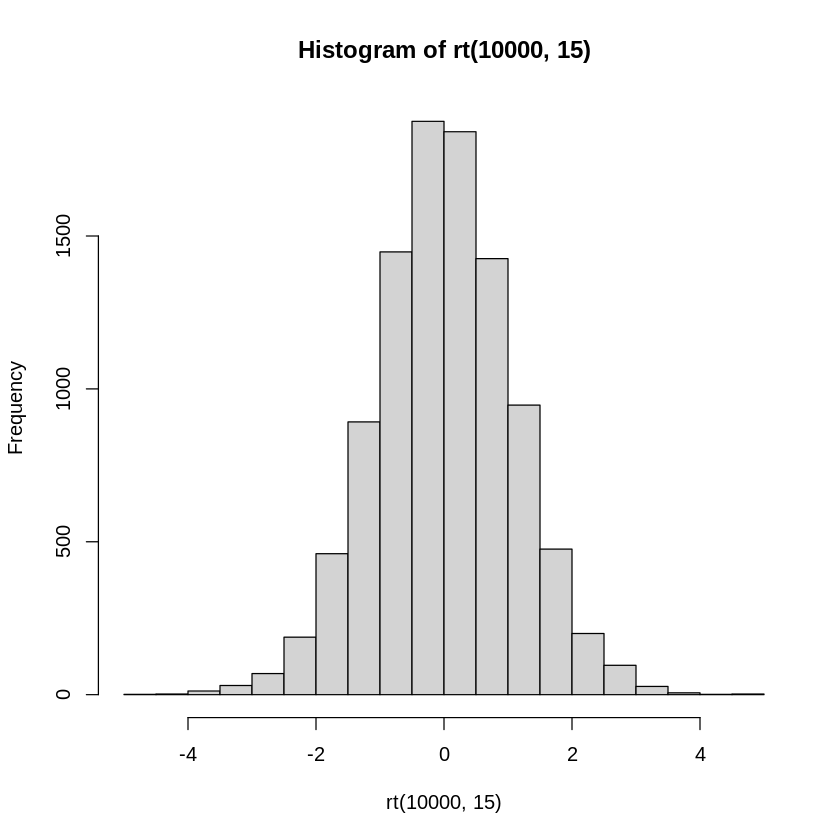

In [15]:
# H0 é falso: caso Student-t com 15 g.l
hist(rt(10000, 15))

In [16]:
# Estudo de Simulação Quando H0 é falso: caso Student-t
for (j in 1:length(size_n)) {
  for (i in 1:replicacoes) {
    ## Controlamos a semente
    set.seed(i)
    ## Simulamos dados
    x <- rt(size_n[j], 15)
    ## Aplicamos os testes
    p_valores[i, ] <- c(ks.test(x, "pnorm")$p.value, 
                        jarque.bera.test(x)$p.value,
                        shapiro.test(x)$p.value,
                        CramerVonMisesTest(x)$p.value)
  }
  ## Calculamos a proporcao de vezes que rejeitamos H0
  tabela[j, ] <- apply(p_valores < 0.05, 2, mean)
}
tabela

,KS,Jarque-Bera,Shapiro,Cramer
10,0.0538,0.0152,0.0624,0.0620
20,0.0552,0.0514,0.0784,0.0696
50,0.0586,0.1130,0.1102,0.0804
100,0.0514,0.1866,0.1466,0.0918
500,0.0580,0.4826,0.3810,0.1864
1000,0.0600,0.7114,0.6052,0.3408


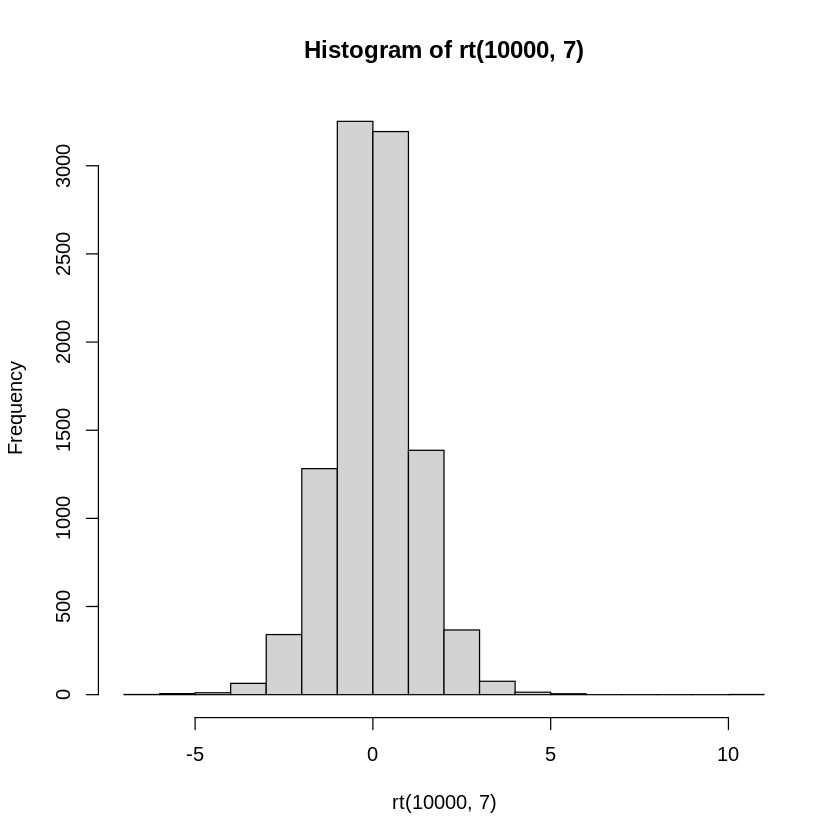

In [17]:
# H0 é falso: caso Student-t com 7 g.l
hist(rt(10000, 7))

In [18]:
# Estudo de Simulação Quando H0 é falso: caso Student-t
for (j in 1:length(size_n)) {
  for (i in 1:replicacoes) {
    ## Controlamos a semente
    set.seed(i)
    ## Simulamos dados
    x <- rt(size_n[j], 7)
    ## Aplicamos os testes
    p_valores[i, ] <- c(ks.test(x, "pnorm")$p.value, 
                        jarque.bera.test(x)$p.value,
                        shapiro.test(x)$p.value,
                        CramerVonMisesTest(x)$p.value)
  }
  ## Calculamos a proporcao de vezes que rejeitamos H0
  tabela[j, ] <- apply(p_valores < 0.05, 2, mean)
}
tabela

,KS,Jarque-Bera,Shapiro,Cramer
10,0.0608,0.0262,0.0844,0.0760
20,0.0570,0.1112,0.1304,0.1076
50,0.0646,0.2712,0.2372,0.1610
100,0.0642,0.4390,0.3720,0.2492
500,0.0976,0.9324,0.8970,0.7600
1000,0.1786,0.9978,0.9938,0.9614


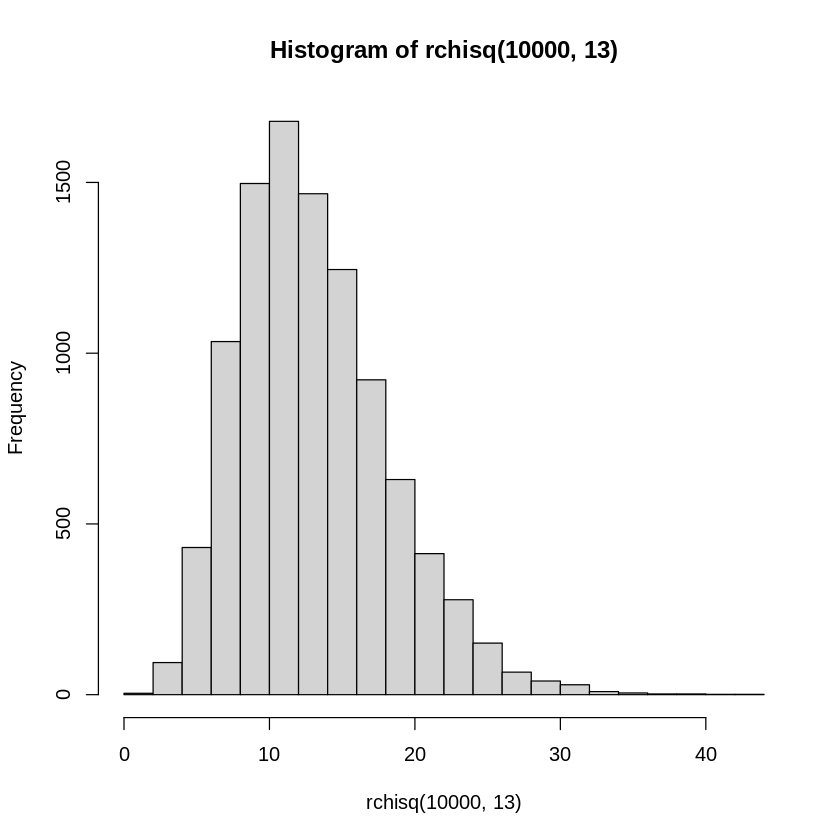

In [19]:
# H0 é falso: caso Chi2
hist(rchisq(10000, 13))

In [20]:
# Estudo de Simulação Quando H0 é falso: caso Chi2
for (j in 1:length(size_n)) {
  for (i in 1:replicacoes) {
    ## Controlamos a semente
    set.seed(i)
    ## Simulamos dados
    x <- rchisq(size_n[j], 13)
    ## Aplicamos os testes
    p_valores[i, ] <- c(ks.test(x, "pnorm")$p.value, 
                        jarque.bera.test(x)$p.value,
                        shapiro.test(x)$p.value,
                        CramerVonMisesTest(x)$p.value)
  }
  ## Calculamos a proporcao de vezes que rejeitamos H0
  tabela[j, ] <- apply(p_valores < 0.05, 2, mean)
}
tabela

,KS,Jarque-Bera,Shapiro,Cramer
10,1,0.0302,0.1024,0.0894
20,1,0.1162,0.1916,0.1470
50,1,0.3392,0.4628,0.3222
100,1,0.6738,0.8028,0.6140
500,1,1.0000,1.0000,0.9998
1000,1,1.0000,1.0000,1.0000
